## Predicting Crashes in Financial Markets - RNN LSTM
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: RNN LSTM
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1: yes)
- Crash definition: Drawdown in 99.5% quantile

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn import metrics
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
# -------------------- data preparation -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data_5 import DataLoader
os.chdir('/home/roman/Documents/Projects/Bubbles/data')

datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv', '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.091, -0.109, -0.120, -0.144, -0.166, -0.110, -0.233] # <-- Jacobsson
#crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264] # <-- Sornette
df_combined, drawdowns, crashes = data.get_df_combined(crash_thresholds)

months = 3               # <-- predict if crash n months ahead
select_features = False  # <-- if True: 8 time windows for mean price change and vol year
sequence = 5             # <-- number of days lookback as input(only if select_features=False)
additional_feat = False  # <-- if True: add mean price change and volatility for 4 time widnows over 252 days
batch_size = 64          # <-- batch size needs to be specified to satisfy stateful=True
#vol = False             # <-- if True: include 10 day volatility for each day in sequence (only in prepare_data_2)
dfs_xy = data.get_df_xy(months=months, sequence=sequence, df_combined=df_combined, crashes=crashes, \
                        batch_size=batch_size, select_features=select_features, additional_feat=additional_feat)

In [3]:
# -------------------- RNN LSTM model -------------------- #
model_name = 'RNN LSTM'
neurons = 50
dropout = 0
optimizer = 'adam'
loss = 'mse'   # 'binary_crossentropy'
activation = 'linear'
stateful = True
inp_tsteps = sequence + 8 * additional_feat
def rnn_lstm(inp_tsteps, inp_dim, neurons, dropout):
    model = Sequential()
    #model.add(LSTM(neurons, input_shape=(inp_tsteps, inp_dim), return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, inp_tsteps, inp_dim), \
                   stateful=stateful, return_sequences=True))
    #model.add(Dropout(dropout))
    #model.add(LSTM(neurons, return_sequences=True))
    model.add(LSTM(neurons, stateful=stateful, return_sequences=False))
    #model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))   # 'sigmoid'
    return model
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=1, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (64, 5, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (64, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (64, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [4]:
# -------------------- Train and test RNN LSTM model -------------------- #
epochs = 100
y_train_all = []
y_test_all = []
y_pred_tr_all = []
y_pred_t_all = []
os.chdir('/home/roman/Documents/Projects/Bubbles/models/model_weights/')
for test_data in dataset_names:
    model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=1, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
    print('------------------------------------------------------')
    print('Testdata: ' + str(test_data))
    print('------------------------------------------------------')
    for e in range(epochs):
        np_train_l = data.get_train_stateful(dfs_xy, dataset_names, test_data=test_data)
        for i, np_tr in enumerate(np_train_l):
            print('epoch: ' + str(e + 1) + ' dataset: ' + str(i + 1))
            x_tr = np_tr[:, 0:-1]             
            x_tr = np.expand_dims(x_tr, axis=2)
            y_tr = np_tr[:, -1].astype(int)   
            model.fit(x_tr, y_tr, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
            model.reset_states()
            if (e + 1) % 5 == 0 and i == len(np_train_l) - 1:
                model.save_weights('stateful_{0}_{1}.hdf5'.format(test_data, e + 1))

------------------------------------------------------
Testdata: S&P 500
------------------------------------------------------
epoch: 1 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 4s 337us/step - loss: 0.0451 - acc: 0.9540
epoch: 1 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 2s 343us/step - loss: 0.0478 - acc: 0.9513
epoch: 1 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 224us/step - loss: 0.0419 - acc: 0.9566
epoch: 1 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 218us/step - loss: 0.0376 - acc: 0.9614
epoch: 1 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 284us/step - loss: 0.0507 - acc: 0.9471
epoch: 1 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 218us/step - loss: 0.0402 - acc: 0.9585
epoch: 2 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 217us/step - loss: 0.0445 - acc: 0.9540
epoch: 2 dataset: 2
Epoch 1/1
5568/5568 [=

7680/7680 [==============================] - 2s 249us/step - loss: 0.0415 - acc: 0.9566
epoch: 12 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 202us/step - loss: 0.0360 - acc: 0.9614
epoch: 12 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 204us/step - loss: 0.0480 - acc: 0.9471
epoch: 12 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 204us/step - loss: 0.0384 - acc: 0.9585
epoch: 13 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 213us/step - loss: 0.0442 - acc: 0.9540
epoch: 13 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 224us/step - loss: 0.0435 - acc: 0.9513
epoch: 13 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 204us/step - loss: 0.0415 - acc: 0.9566
epoch: 13 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 232us/step - loss: 0.0359 - acc: 0.9614
epoch: 13 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1

6848/6848 [==============================] - 2s 263us/step - loss: 0.0466 - acc: 0.9477
epoch: 23 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 202us/step - loss: 0.0381 - acc: 0.9585
epoch: 24 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 217us/step - loss: 0.0441 - acc: 0.9540
epoch: 24 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 181us/step - loss: 0.0422 - acc: 0.9515
epoch: 24 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 174us/step - loss: 0.0413 - acc: 0.9566
epoch: 24 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 175us/step - loss: 0.0357 - acc: 0.9614
epoch: 24 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 173us/step - loss: 0.0466 - acc: 0.9474
epoch: 24 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 182us/step - loss: 0.0381 - acc: 0.9585
epoch: 25 dataset: 1
Epoch 1/1
13056/13056 [==============================] -

13056/13056 [==============================] - 3s 224us/step - loss: 0.0440 - acc: 0.9544
epoch: 35 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 211us/step - loss: 0.0395 - acc: 0.9551
epoch: 35 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 202us/step - loss: 0.0413 - acc: 0.9566
epoch: 35 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 262us/step - loss: 0.0356 - acc: 0.9614
epoch: 35 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 331us/step - loss: 0.0456 - acc: 0.9485
epoch: 35 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 2s 285us/step - loss: 0.0381 - acc: 0.9583
epoch: 36 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 5s 420us/step - loss: 0.0440 - acc: 0.9543
epoch: 36 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 204us/step - loss: 0.0394 - acc: 0.9555
epoch: 36 dataset: 3
Epoch 1/1
7680/7680 [==============================] -

7680/7680 [==============================] - 1s 187us/step - loss: 0.0415 - acc: 0.9566
epoch: 46 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 187us/step - loss: 0.0349 - acc: 0.9626
epoch: 46 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 186us/step - loss: 0.0456 - acc: 0.9486
epoch: 46 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 220us/step - loss: 0.0378 - acc: 0.9588
epoch: 47 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 2s 183us/step - loss: 0.0438 - acc: 0.9543
epoch: 47 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 185us/step - loss: 0.0355 - acc: 0.9601
epoch: 47 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 186us/step - loss: 0.0415 - acc: 0.9566
epoch: 47 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 190us/step - loss: 0.0349 - acc: 0.9626
epoch: 47 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1

6848/6848 [==============================] - 2s 321us/step - loss: 0.0453 - acc: 0.9489
epoch: 57 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 193us/step - loss: 0.0370 - acc: 0.9587
epoch: 58 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 214us/step - loss: 0.0437 - acc: 0.9543
epoch: 58 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 187us/step - loss: 0.0317 - acc: 0.9648
epoch: 58 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 184us/step - loss: 0.0415 - acc: 0.9566
epoch: 58 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 228us/step - loss: 0.0347 - acc: 0.9624
epoch: 58 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 231us/step - loss: 0.0450 - acc: 0.9487
epoch: 58 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 200us/step - loss: 0.0369 - acc: 0.9588
epoch: 59 dataset: 1
Epoch 1/1
13056/13056 [==============================] -

5568/5568 [==============================] - 2s 378us/step - loss: 0.0289 - acc: 0.9698
epoch: 69 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 227us/step - loss: 0.0415 - acc: 0.9566
epoch: 69 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 3s 507us/step - loss: 0.0341 - acc: 0.9632
epoch: 69 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 329us/step - loss: 0.0434 - acc: 0.9512
epoch: 69 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 243us/step - loss: 0.0361 - acc: 0.9600
epoch: 70 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 226us/step - loss: 0.0433 - acc: 0.9546
epoch: 70 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 263us/step - loss: 0.0284 - acc: 0.9711
epoch: 70 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 219us/step - loss: 0.0414 - acc: 0.9566
epoch: 70 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1

5056/5056 [==============================] - 2s 299us/step - loss: 0.0337 - acc: 0.9650
epoch: 80 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 275us/step - loss: 0.0423 - acc: 0.9524
epoch: 80 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 236us/step - loss: 0.0358 - acc: 0.9600
epoch: 81 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 4s 284us/step - loss: 0.0430 - acc: 0.9550
epoch: 81 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 2s 325us/step - loss: 0.0288 - acc: 0.9711
epoch: 81 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 224us/step - loss: 0.0413 - acc: 0.9566
epoch: 81 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 2s 317us/step - loss: 0.0335 - acc: 0.9648
epoch: 81 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 235us/step - loss: 0.0421 - acc: 0.9531
epoch: 81 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1

6144/6144 [==============================] - 2s 274us/step - loss: 0.0349 - acc: 0.9608
epoch: 92 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 200us/step - loss: 0.0429 - acc: 0.9550
epoch: 92 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 196us/step - loss: 0.0267 - acc: 0.9714
epoch: 92 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 196us/step - loss: 0.0413 - acc: 0.9566
epoch: 92 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 201us/step - loss: 0.0332 - acc: 0.9646
epoch: 92 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 205us/step - loss: 0.0407 - acc: 0.9547
epoch: 92 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 202us/step - loss: 0.0349 - acc: 0.9613
epoch: 93 dataset: 1
Epoch 1/1
13056/13056 [==============================] - 3s 211us/step - loss: 0.0429 - acc: 0.9553
epoch: 93 dataset: 2
Epoch 1/1
5568/5568 [==============================] -

17088/17088 [==============================] - 3s 180us/step - loss: 0.0407 - acc: 0.9575
epoch: 3 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 183us/step - loss: 0.0468 - acc: 0.9513
epoch: 3 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 176us/step - loss: 0.0417 - acc: 0.9566
epoch: 3 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 180us/step - loss: 0.0372 - acc: 0.9614
epoch: 3 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 178us/step - loss: 0.0501 - acc: 0.9471
epoch: 3 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 179us/step - loss: 0.0398 - acc: 0.9585
epoch: 4 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0406 - acc: 0.9575
epoch: 4 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 177us/step - loss: 0.0478 - acc: 0.9508
epoch: 4 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 180u

5056/5056 [==============================] - 1s 166us/step - loss: 0.0360 - acc: 0.9614
epoch: 14 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 155us/step - loss: 0.0477 - acc: 0.9471
epoch: 14 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 167us/step - loss: 0.0379 - acc: 0.9585
epoch: 15 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 163us/step - loss: 0.0391 - acc: 0.9575
epoch: 15 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 161us/step - loss: 0.0469 - acc: 0.9513
epoch: 15 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 168us/step - loss: 0.0415 - acc: 0.9566
epoch: 15 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 163us/step - loss: 0.0360 - acc: 0.9614
epoch: 15 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 164us/step - loss: 0.0476 - acc: 0.9471
epoch: 15 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1

6144/6144 [==============================] - 1s 194us/step - loss: 0.0377 - acc: 0.9585
epoch: 26 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 183us/step - loss: 0.0388 - acc: 0.9575
epoch: 26 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 170us/step - loss: 0.0458 - acc: 0.9515
epoch: 26 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 163us/step - loss: 0.0414 - acc: 0.9566
epoch: 26 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 160us/step - loss: 0.0358 - acc: 0.9614
epoch: 26 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 164us/step - loss: 0.0468 - acc: 0.9471
epoch: 26 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 162us/step - loss: 0.0377 - acc: 0.9585
epoch: 27 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 164us/step - loss: 0.0388 - acc: 0.9575
epoch: 27 dataset: 2
Epoch 1/1
5568/5568 [==============================] -

5568/5568 [==============================] - 1s 179us/step - loss: 0.0443 - acc: 0.9529
epoch: 37 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 167us/step - loss: 0.0413 - acc: 0.9566
epoch: 37 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 2s 329us/step - loss: 0.0356 - acc: 0.9614
epoch: 37 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 279us/step - loss: 0.0465 - acc: 0.9474
epoch: 37 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 2s 319us/step - loss: 0.0376 - acc: 0.9585
epoch: 38 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 194us/step - loss: 0.0386 - acc: 0.9576
epoch: 38 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 213us/step - loss: 0.0438 - acc: 0.9533
epoch: 38 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 229us/step - loss: 0.0412 - acc: 0.9566
epoch: 38 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1

5056/5056 [==============================] - 1s 186us/step - loss: 0.0357 - acc: 0.9614
epoch: 48 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 186us/step - loss: 0.0461 - acc: 0.9479
epoch: 48 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 200us/step - loss: 0.0374 - acc: 0.9585
epoch: 49 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 4s 218us/step - loss: 0.0384 - acc: 0.9579
epoch: 49 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 184us/step - loss: 0.0401 - acc: 0.9555
epoch: 49 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 187us/step - loss: 0.0412 - acc: 0.9565
epoch: 49 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 252us/step - loss: 0.0357 - acc: 0.9614
epoch: 49 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 196us/step - loss: 0.0461 - acc: 0.9477
epoch: 49 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 2

6144/6144 [==============================] - 1s 196us/step - loss: 0.0371 - acc: 0.9585
epoch: 60 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 190us/step - loss: 0.0383 - acc: 0.9577
epoch: 60 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 187us/step - loss: 0.0375 - acc: 0.9608
epoch: 60 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 195us/step - loss: 0.0410 - acc: 0.9566
epoch: 60 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 193us/step - loss: 0.0349 - acc: 0.9626
epoch: 60 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 193us/step - loss: 0.0454 - acc: 0.9489
epoch: 60 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 190us/step - loss: 0.0371 - acc: 0.9585
epoch: 61 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 4s 244us/step - loss: 0.0383 - acc: 0.9577
epoch: 61 dataset: 2
Epoch 1/1
5568/5568 [==============================] -

5568/5568 [==============================] - 1s 177us/step - loss: 0.0318 - acc: 0.9680
epoch: 71 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 179us/step - loss: 0.0409 - acc: 0.9568
epoch: 71 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 178us/step - loss: 0.0338 - acc: 0.9634
epoch: 71 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 180us/step - loss: 0.0441 - acc: 0.9508
epoch: 71 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 180us/step - loss: 0.0365 - acc: 0.9587
epoch: 72 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 176us/step - loss: 0.0378 - acc: 0.9583
epoch: 72 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 181us/step - loss: 0.0349 - acc: 0.9617
epoch: 72 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0409 - acc: 0.9569
epoch: 72 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1

5056/5056 [==============================] - 1s 212us/step - loss: 0.0329 - acc: 0.9642
epoch: 82 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 227us/step - loss: 0.0429 - acc: 0.9522
epoch: 82 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 198us/step - loss: 0.0347 - acc: 0.9598
epoch: 83 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 4s 211us/step - loss: 0.0372 - acc: 0.9594
epoch: 83 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 224us/step - loss: 0.0320 - acc: 0.9675
epoch: 83 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 214us/step - loss: 0.0407 - acc: 0.9569
epoch: 83 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 257us/step - loss: 0.0328 - acc: 0.9646
epoch: 83 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 227us/step - loss: 0.0425 - acc: 0.9522
epoch: 83 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1

6144/6144 [==============================] - 1s 194us/step - loss: 0.0333 - acc: 0.9613
epoch: 94 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 5s 265us/step - loss: 0.0366 - acc: 0.9602
epoch: 94 dataset: 2
Epoch 1/1
5568/5568 [==============================] - 1s 223us/step - loss: 0.0317 - acc: 0.9679
epoch: 94 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 2s 276us/step - loss: 0.0402 - acc: 0.9572
epoch: 94 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 196us/step - loss: 0.0322 - acc: 0.9654
epoch: 94 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 195us/step - loss: 0.0410 - acc: 0.9533
epoch: 94 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 2s 330us/step - loss: 0.0334 - acc: 0.9614
epoch: 95 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 5s 290us/step - loss: 0.0364 - acc: 0.9604
epoch: 95 dataset: 2
Epoch 1/1
5568/5568 [==============================] -

17088/17088 [==============================] - 3s 181us/step - loss: 0.0405 - acc: 0.9575
epoch: 5 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0440 - acc: 0.9540
epoch: 5 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 185us/step - loss: 0.0416 - acc: 0.9566
epoch: 5 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 184us/step - loss: 0.0368 - acc: 0.9614
epoch: 5 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 182us/step - loss: 0.0490 - acc: 0.9471
epoch: 5 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 180us/step - loss: 0.0395 - acc: 0.9585
epoch: 6 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 184us/step - loss: 0.0403 - acc: 0.9575
epoch: 6 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 182us/step - loss: 0.0440 - acc: 0.9540
epoch: 6 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 

7680/7680 [==============================] - 1s 189us/step - loss: 0.0410 - acc: 0.9566
epoch: 16 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 179us/step - loss: 0.0360 - acc: 0.9614
epoch: 16 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 180us/step - loss: 0.0472 - acc: 0.9476
epoch: 16 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 215us/step - loss: 0.0375 - acc: 0.9585
epoch: 17 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 176us/step - loss: 0.0389 - acc: 0.9576
epoch: 17 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 3s 193us/step - loss: 0.0447 - acc: 0.9540
epoch: 17 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 178us/step - loss: 0.0410 - acc: 0.9566
epoch: 17 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 177us/step - loss: 0.0360 - acc: 0.9614
epoch: 17 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 192us/step - loss: 0.0463 - acc: 0.9485
epoch: 27 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 193us/step - loss: 0.0374 - acc: 0.9585
epoch: 28 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 4s 220us/step - loss: 0.0385 - acc: 0.9579
epoch: 28 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 174us/step - loss: 0.0444 - acc: 0.9540
epoch: 28 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 174us/step - loss: 0.0408 - acc: 0.9566
epoch: 28 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 181us/step - loss: 0.0358 - acc: 0.9614
epoch: 28 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 177us/step - loss: 0.0462 - acc: 0.9485
epoch: 28 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 170us/step - loss: 0.0374 - acc: 0.9585
epoch: 29 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 173us/step - loss: 0.0385 - acc: 0.9579
epoch: 39 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 173us/step - loss: 0.0441 - acc: 0.9545
epoch: 39 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 171us/step - loss: 0.0408 - acc: 0.9568
epoch: 39 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 284us/step - loss: 0.0349 - acc: 0.9622
epoch: 39 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 2s 227us/step - loss: 0.0452 - acc: 0.9508
epoch: 39 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 181us/step - loss: 0.0375 - acc: 0.9585
epoch: 40 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0385 - acc: 0.9580
epoch: 40 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 3s 236us/step - loss: 0.0441 - acc: 0.9545
epoch: 40 dataset: 3
Epoch 1/1
7680/7680 [=============================

7680/7680 [==============================] - 1s 171us/step - loss: 0.0407 - acc: 0.9568
epoch: 50 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 174us/step - loss: 0.0342 - acc: 0.9636
epoch: 50 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 176us/step - loss: 0.0432 - acc: 0.9520
epoch: 50 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0372 - acc: 0.9585
epoch: 51 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0382 - acc: 0.9583
epoch: 51 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 173us/step - loss: 0.0438 - acc: 0.9547
epoch: 51 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 175us/step - loss: 0.0407 - acc: 0.9568
epoch: 51 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 172us/step - loss: 0.0341 - acc: 0.9638
epoch: 51 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 188us/step - loss: 0.0421 - acc: 0.9537
epoch: 61 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 173us/step - loss: 0.0359 - acc: 0.9593
epoch: 62 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 173us/step - loss: 0.0377 - acc: 0.9592
epoch: 62 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 3s 227us/step - loss: 0.0434 - acc: 0.9552
epoch: 62 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 173us/step - loss: 0.0407 - acc: 0.9568
epoch: 62 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 181us/step - loss: 0.0336 - acc: 0.9646
epoch: 62 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 175us/step - loss: 0.0432 - acc: 0.9511
epoch: 62 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 175us/step - loss: 0.0363 - acc: 0.9591
epoch: 63 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 173us/step - loss: 0.0371 - acc: 0.9597
epoch: 73 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 171us/step - loss: 0.0435 - acc: 0.9545
epoch: 73 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 170us/step - loss: 0.0405 - acc: 0.9568
epoch: 73 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 172us/step - loss: 0.0331 - acc: 0.9652
epoch: 73 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 174us/step - loss: 0.0416 - acc: 0.9536
epoch: 73 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0354 - acc: 0.9596
epoch: 74 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 172us/step - loss: 0.0371 - acc: 0.9597
epoch: 74 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 173us/step - loss: 0.0435 - acc: 0.9548
epoch: 74 dataset: 3
Epoch 1/1
7680/7680 [=============================

7680/7680 [==============================] - 1s 176us/step - loss: 0.0404 - acc: 0.9570
epoch: 84 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 171us/step - loss: 0.0328 - acc: 0.9656
epoch: 84 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 174us/step - loss: 0.0413 - acc: 0.9525
epoch: 84 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 174us/step - loss: 0.0356 - acc: 0.9598
epoch: 85 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 171us/step - loss: 0.0369 - acc: 0.9596
epoch: 85 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 176us/step - loss: 0.0428 - acc: 0.9555
epoch: 85 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 175us/step - loss: 0.0403 - acc: 0.9570
epoch: 85 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 174us/step - loss: 0.0329 - acc: 0.9650
epoch: 85 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 180us/step - loss: 0.0424 - acc: 0.9527
epoch: 95 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 175us/step - loss: 0.0343 - acc: 0.9604
epoch: 96 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0363 - acc: 0.9607
epoch: 96 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 174us/step - loss: 0.0423 - acc: 0.9560
epoch: 96 dataset: 3
Epoch 1/1
7680/7680 [==============================] - 1s 174us/step - loss: 0.0400 - acc: 0.9573
epoch: 96 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 178us/step - loss: 0.0326 - acc: 0.9662
epoch: 96 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 174us/step - loss: 0.0398 - acc: 0.9546
epoch: 96 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 170us/step - loss: 0.0335 - acc: 0.9619
epoch: 97 dataset: 1
Epoch 1/1
17088/17088 [==============================]

epoch: 7 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0399 - acc: 0.9575
epoch: 7 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 175us/step - loss: 0.0443 - acc: 0.9540
epoch: 7 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 175us/step - loss: 0.0439 - acc: 0.9513
epoch: 7 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 178us/step - loss: 0.0362 - acc: 0.9614
epoch: 7 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 180us/step - loss: 0.0485 - acc: 0.9471
epoch: 7 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0386 - acc: 0.9585
epoch: 8 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 181us/step - loss: 0.0396 - acc: 0.9575
epoch: 8 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0445 - acc: 0.9540
epoch: 8 dataset: 3
Epoch 1/1
5568/5568 [=======

5568/5568 [==============================] - 1s 182us/step - loss: 0.0431 - acc: 0.9513
epoch: 18 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 174us/step - loss: 0.0358 - acc: 0.9614
epoch: 18 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 179us/step - loss: 0.0471 - acc: 0.9474
epoch: 18 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0378 - acc: 0.9585
epoch: 19 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 176us/step - loss: 0.0388 - acc: 0.9576
epoch: 19 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0446 - acc: 0.9539
epoch: 19 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 188us/step - loss: 0.0429 - acc: 0.9515
epoch: 19 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 178us/step - loss: 0.0358 - acc: 0.9614
epoch: 19 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 178us/step - loss: 0.0463 - acc: 0.9490
epoch: 29 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 183us/step - loss: 0.0380 - acc: 0.9583
epoch: 30 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0386 - acc: 0.9579
epoch: 30 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 176us/step - loss: 0.0445 - acc: 0.9538
epoch: 30 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 179us/step - loss: 0.0412 - acc: 0.9522
epoch: 30 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 176us/step - loss: 0.0357 - acc: 0.9612
epoch: 30 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 178us/step - loss: 0.0462 - acc: 0.9489
epoch: 30 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 179us/step - loss: 0.0379 - acc: 0.9583
epoch: 31 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 182us/step - loss: 0.0385 - acc: 0.9581
epoch: 41 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 182us/step - loss: 0.0445 - acc: 0.9540
epoch: 41 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 179us/step - loss: 0.0379 - acc: 0.9571
epoch: 41 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 185us/step - loss: 0.0354 - acc: 0.9622
epoch: 41 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 181us/step - loss: 0.0458 - acc: 0.9492
epoch: 41 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0378 - acc: 0.9583
epoch: 42 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0385 - acc: 0.9582
epoch: 42 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0445 - acc: 0.9540
epoch: 42 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 176us/step - loss: 0.0362 - acc: 0.9589
epoch: 52 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 170us/step - loss: 0.0354 - acc: 0.9622
epoch: 52 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 181us/step - loss: 0.0455 - acc: 0.9498
epoch: 52 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0377 - acc: 0.9583
epoch: 53 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0383 - acc: 0.9582
epoch: 53 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0442 - acc: 0.9543
epoch: 53 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 180us/step - loss: 0.0350 - acc: 0.9617
epoch: 53 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 175us/step - loss: 0.0353 - acc: 0.9624
epoch: 53 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 188us/step - loss: 0.0448 - acc: 0.9502
epoch: 63 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0374 - acc: 0.9588
epoch: 64 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0381 - acc: 0.9585
epoch: 64 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0440 - acc: 0.9545
epoch: 64 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 179us/step - loss: 0.0339 - acc: 0.9610
epoch: 64 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 178us/step - loss: 0.0351 - acc: 0.9620
epoch: 64 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 178us/step - loss: 0.0449 - acc: 0.9496
epoch: 64 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 176us/step - loss: 0.0373 - acc: 0.9588
epoch: 65 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 177us/step - loss: 0.0373 - acc: 0.9598
epoch: 75 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0435 - acc: 0.9551
epoch: 75 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 178us/step - loss: 0.0322 - acc: 0.9635
epoch: 75 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 175us/step - loss: 0.0341 - acc: 0.9642
epoch: 75 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 180us/step - loss: 0.0437 - acc: 0.9511
epoch: 75 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 176us/step - loss: 0.0360 - acc: 0.9601
epoch: 76 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 180us/step - loss: 0.0374 - acc: 0.9597
epoch: 76 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0435 - acc: 0.9552
epoch: 76 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 180us/step - loss: 0.0312 - acc: 0.9668
epoch: 86 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 181us/step - loss: 0.0336 - acc: 0.9638
epoch: 86 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 174us/step - loss: 0.0424 - acc: 0.9533
epoch: 86 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0348 - acc: 0.9613
epoch: 87 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0365 - acc: 0.9607
epoch: 87 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0426 - acc: 0.9558
epoch: 87 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 179us/step - loss: 0.0312 - acc: 0.9662
epoch: 87 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 183us/step - loss: 0.0336 - acc: 0.9640
epoch: 87 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 178us/step - loss: 0.0415 - acc: 0.9530
epoch: 97 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 175us/step - loss: 0.0343 - acc: 0.9616
epoch: 98 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0365 - acc: 0.9606
epoch: 98 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0421 - acc: 0.9560
epoch: 98 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 181us/step - loss: 0.0314 - acc: 0.9644
epoch: 98 dataset: 4
Epoch 1/1
5056/5056 [==============================] - 1s 182us/step - loss: 0.0337 - acc: 0.9642
epoch: 98 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 177us/step - loss: 0.0414 - acc: 0.9531
epoch: 98 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 175us/step - loss: 0.0343 - acc: 0.9614
epoch: 99 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 176us/step - loss: 0.0397 - acc: 0.9575
epoch: 9 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0444 - acc: 0.9540
epoch: 9 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 179us/step - loss: 0.0439 - acc: 0.9513
epoch: 9 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 178us/step - loss: 0.0415 - acc: 0.9566
epoch: 9 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 178us/step - loss: 0.0482 - acc: 0.9471
epoch: 9 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 180us/step - loss: 0.0386 - acc: 0.9585
epoch: 10 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0395 - acc: 0.9575
epoch: 10 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0444 - acc: 0.9540
epoch: 10 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 

5568/5568 [==============================] - 1s 183us/step - loss: 0.0432 - acc: 0.9511
epoch: 20 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0413 - acc: 0.9566
epoch: 20 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 180us/step - loss: 0.0468 - acc: 0.9477
epoch: 20 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 182us/step - loss: 0.0378 - acc: 0.9585
epoch: 21 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 182us/step - loss: 0.0388 - acc: 0.9576
epoch: 21 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 176us/step - loss: 0.0447 - acc: 0.9537
epoch: 21 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 177us/step - loss: 0.0431 - acc: 0.9515
epoch: 21 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 179us/step - loss: 0.0413 - acc: 0.9566
epoch: 21 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 180us/step - loss: 0.0462 - acc: 0.9480
epoch: 31 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 180us/step - loss: 0.0378 - acc: 0.9583
epoch: 32 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0385 - acc: 0.9579
epoch: 32 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0446 - acc: 0.9537
epoch: 32 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 180us/step - loss: 0.0419 - acc: 0.9522
epoch: 32 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 179us/step - loss: 0.0412 - acc: 0.9565
epoch: 32 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 176us/step - loss: 0.0462 - acc: 0.9485
epoch: 32 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 181us/step - loss: 0.0378 - acc: 0.9583
epoch: 33 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 178us/step - loss: 0.0384 - acc: 0.9580
epoch: 43 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 181us/step - loss: 0.0444 - acc: 0.9541
epoch: 43 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 180us/step - loss: 0.0396 - acc: 0.9549
epoch: 43 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 178us/step - loss: 0.0411 - acc: 0.9566
epoch: 43 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 176us/step - loss: 0.0457 - acc: 0.9492
epoch: 43 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 181us/step - loss: 0.0377 - acc: 0.9585
epoch: 44 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 181us/step - loss: 0.0384 - acc: 0.9580
epoch: 44 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0444 - acc: 0.9541
epoch: 44 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 182us/step - loss: 0.0369 - acc: 0.9580
epoch: 54 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 181us/step - loss: 0.0411 - acc: 0.9568
epoch: 54 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 179us/step - loss: 0.0455 - acc: 0.9490
epoch: 54 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 180us/step - loss: 0.0376 - acc: 0.9583
epoch: 55 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0381 - acc: 0.9580
epoch: 55 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0442 - acc: 0.9544
epoch: 55 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 183us/step - loss: 0.0356 - acc: 0.9594
epoch: 55 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 181us/step - loss: 0.0411 - acc: 0.9566
epoch: 55 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 178us/step - loss: 0.0443 - acc: 0.9502
epoch: 65 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0374 - acc: 0.9587
epoch: 66 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0377 - acc: 0.9591
epoch: 66 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0437 - acc: 0.9548
epoch: 66 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 182us/step - loss: 0.0301 - acc: 0.9662
epoch: 66 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 178us/step - loss: 0.0411 - acc: 0.9568
epoch: 66 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 182us/step - loss: 0.0444 - acc: 0.9502
epoch: 66 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0376 - acc: 0.9585
epoch: 67 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 179us/step - loss: 0.0371 - acc: 0.9597
epoch: 77 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 176us/step - loss: 0.0433 - acc: 0.9548
epoch: 77 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 174us/step - loss: 0.0286 - acc: 0.9691
epoch: 77 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 177us/step - loss: 0.0411 - acc: 0.9569
epoch: 77 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 182us/step - loss: 0.0434 - acc: 0.9512
epoch: 77 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 179us/step - loss: 0.0360 - acc: 0.9598
epoch: 78 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0371 - acc: 0.9595
epoch: 78 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0432 - acc: 0.9550
epoch: 78 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 177us/step - loss: 0.0254 - acc: 0.9745
epoch: 88 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 174us/step - loss: 0.0408 - acc: 0.9572
epoch: 88 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 178us/step - loss: 0.0419 - acc: 0.9530
epoch: 88 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0358 - acc: 0.9600
epoch: 89 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0367 - acc: 0.9604
epoch: 89 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 181us/step - loss: 0.0424 - acc: 0.9557
epoch: 89 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 180us/step - loss: 0.0271 - acc: 0.9718
epoch: 89 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 187us/step - loss: 0.0409 - acc: 0.9573
epoch: 89 dataset: 5
Epoch 1/1
6848/6848 [==============================] -

6848/6848 [==============================] - 1s 182us/step - loss: 0.0409 - acc: 0.9546
epoch: 99 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 179us/step - loss: 0.0345 - acc: 0.9611
epoch: 100 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0364 - acc: 0.9606
epoch: 100 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0415 - acc: 0.9563
epoch: 100 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 176us/step - loss: 0.0280 - acc: 0.9702
epoch: 100 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 181us/step - loss: 0.0408 - acc: 0.9572
epoch: 100 dataset: 5
Epoch 1/1
6848/6848 [==============================] - 1s 177us/step - loss: 0.0410 - acc: 0.9547
epoch: 100 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 182us/step - loss: 0.0343 - acc: 0.9618
------------------------------------------------------
Testdata: SMI


17088/17088 [==============================] - 3s 182us/step - loss: 0.0397 - acc: 0.9575
epoch: 11 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 175us/step - loss: 0.0444 - acc: 0.9540
epoch: 11 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 177us/step - loss: 0.0437 - acc: 0.9513
epoch: 11 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 176us/step - loss: 0.0415 - acc: 0.9566
epoch: 11 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 177us/step - loss: 0.0360 - acc: 0.9614
epoch: 11 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 181us/step - loss: 0.0386 - acc: 0.9585
epoch: 12 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0395 - acc: 0.9575
epoch: 12 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0444 - acc: 0.9540
epoch: 12 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 184us/step - loss: 0.0427 - acc: 0.9513
epoch: 22 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 175us/step - loss: 0.0413 - acc: 0.9566
epoch: 22 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 183us/step - loss: 0.0356 - acc: 0.9614
epoch: 22 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 180us/step - loss: 0.0382 - acc: 0.9585
epoch: 23 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0390 - acc: 0.9576
epoch: 23 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0444 - acc: 0.9542
epoch: 23 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 187us/step - loss: 0.0425 - acc: 0.9517
epoch: 23 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 179us/step - loss: 0.0413 - acc: 0.9566
epoch: 23 dataset: 5
Epoch 1/1
5056/5056 [==============================] -

5056/5056 [==============================] - 1s 184us/step - loss: 0.0354 - acc: 0.9616
epoch: 33 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 185us/step - loss: 0.0380 - acc: 0.9587
epoch: 34 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 176us/step - loss: 0.0388 - acc: 0.9578
epoch: 34 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0444 - acc: 0.9542
epoch: 34 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 183us/step - loss: 0.0402 - acc: 0.9542
epoch: 34 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0413 - acc: 0.9568
epoch: 34 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 175us/step - loss: 0.0353 - acc: 0.9620
epoch: 34 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0380 - acc: 0.9587
epoch: 35 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 179us/step - loss: 0.0388 - acc: 0.9580
epoch: 45 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0442 - acc: 0.9542
epoch: 45 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 177us/step - loss: 0.0380 - acc: 0.9565
epoch: 45 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 179us/step - loss: 0.0415 - acc: 0.9568
epoch: 45 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 173us/step - loss: 0.0352 - acc: 0.9618
epoch: 45 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 184us/step - loss: 0.0380 - acc: 0.9585
epoch: 46 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0388 - acc: 0.9578
epoch: 46 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0441 - acc: 0.9542
epoch: 46 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 180us/step - loss: 0.0327 - acc: 0.9630
epoch: 56 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 181us/step - loss: 0.0415 - acc: 0.9566
epoch: 56 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 182us/step - loss: 0.0343 - acc: 0.9634
epoch: 56 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 189us/step - loss: 0.0378 - acc: 0.9587
epoch: 57 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0385 - acc: 0.9583
epoch: 57 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0439 - acc: 0.9545
epoch: 57 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 182us/step - loss: 0.0325 - acc: 0.9643
epoch: 57 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 179us/step - loss: 0.0414 - acc: 0.9568
epoch: 57 dataset: 5
Epoch 1/1
5056/5056 [==============================] -

5056/5056 [==============================] - 1s 180us/step - loss: 0.0343 - acc: 0.9632
epoch: 67 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0375 - acc: 0.9588
epoch: 68 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 181us/step - loss: 0.0381 - acc: 0.9586
epoch: 68 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0436 - acc: 0.9549
epoch: 68 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 178us/step - loss: 0.0323 - acc: 0.9639
epoch: 68 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0413 - acc: 0.9568
epoch: 68 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 176us/step - loss: 0.0343 - acc: 0.9630
epoch: 68 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0376 - acc: 0.9590
epoch: 69 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 179us/step - loss: 0.0380 - acc: 0.9588
epoch: 79 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0432 - acc: 0.9550
epoch: 79 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 176us/step - loss: 0.0284 - acc: 0.9686
epoch: 79 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0413 - acc: 0.9568
epoch: 79 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 175us/step - loss: 0.0338 - acc: 0.9634
epoch: 79 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 178us/step - loss: 0.0375 - acc: 0.9591
epoch: 80 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 181us/step - loss: 0.0378 - acc: 0.9591
epoch: 80 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 184us/step - loss: 0.0431 - acc: 0.9551
epoch: 80 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 184us/step - loss: 0.0267 - acc: 0.9705
epoch: 90 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 183us/step - loss: 0.0411 - acc: 0.9569
epoch: 90 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 178us/step - loss: 0.0330 - acc: 0.9654
epoch: 90 dataset: 6
Epoch 1/1
6144/6144 [==============================] - 1s 177us/step - loss: 0.0369 - acc: 0.9593
epoch: 91 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 184us/step - loss: 0.0373 - acc: 0.9595
epoch: 91 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0427 - acc: 0.9553
epoch: 91 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 181us/step - loss: 0.0253 - acc: 0.9738
epoch: 91 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 183us/step - loss: 0.0411 - acc: 0.9569
epoch: 91 dataset: 5
Epoch 1/1
5056/5056 [==============================] -

7680/7680 [==============================] - 1s 184us/step - loss: 0.0418 - acc: 0.9566
epoch: 1 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 186us/step - loss: 0.0374 - acc: 0.9614
epoch: 1 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 176us/step - loss: 0.0506 - acc: 0.9471
epoch: 2 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0410 - acc: 0.9575
epoch: 2 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 181us/step - loss: 0.0443 - acc: 0.9540
epoch: 2 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 184us/step - loss: 0.0468 - acc: 0.9513
epoch: 2 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 188us/step - loss: 0.0417 - acc: 0.9566
epoch: 2 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 182us/step - loss: 0.0373 - acc: 0.9614
epoch: 2 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 181u

17088/17088 [==============================] - 3s 184us/step - loss: 0.0394 - acc: 0.9575
epoch: 13 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0443 - acc: 0.9540
epoch: 13 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 182us/step - loss: 0.0437 - acc: 0.9513
epoch: 13 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 177us/step - loss: 0.0414 - acc: 0.9566
epoch: 13 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 181us/step - loss: 0.0359 - acc: 0.9614
epoch: 13 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 181us/step - loss: 0.0475 - acc: 0.9473
epoch: 14 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 176us/step - loss: 0.0393 - acc: 0.9575
epoch: 14 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 181us/step - loss: 0.0444 - acc: 0.9540
epoch: 14 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 187us/step - loss: 0.0422 - acc: 0.9517
epoch: 24 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 192us/step - loss: 0.0413 - acc: 0.9565
epoch: 24 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 184us/step - loss: 0.0357 - acc: 0.9614
epoch: 24 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 187us/step - loss: 0.0465 - acc: 0.9482
epoch: 25 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 179us/step - loss: 0.0391 - acc: 0.9576
epoch: 25 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 183us/step - loss: 0.0443 - acc: 0.9540
epoch: 25 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 179us/step - loss: 0.0419 - acc: 0.9517
epoch: 25 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 182us/step - loss: 0.0413 - acc: 0.9565
epoch: 25 dataset: 5
Epoch 1/1
5056/5056 [==============================] -

5056/5056 [==============================] - 1s 182us/step - loss: 0.0353 - acc: 0.9616
epoch: 35 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 179us/step - loss: 0.0458 - acc: 0.9480
epoch: 36 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 182us/step - loss: 0.0388 - acc: 0.9579
epoch: 36 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 178us/step - loss: 0.0442 - acc: 0.9542
epoch: 36 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 196us/step - loss: 0.0384 - acc: 0.9551
epoch: 36 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 186us/step - loss: 0.0413 - acc: 0.9566
epoch: 36 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 179us/step - loss: 0.0351 - acc: 0.9618
epoch: 36 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 181us/step - loss: 0.0458 - acc: 0.9483
epoch: 37 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 181us/step - loss: 0.0387 - acc: 0.9582
epoch: 47 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0440 - acc: 0.9541
epoch: 47 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 178us/step - loss: 0.0355 - acc: 0.9601
epoch: 47 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0414 - acc: 0.9565
epoch: 47 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 179us/step - loss: 0.0350 - acc: 0.9620
epoch: 47 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 182us/step - loss: 0.0452 - acc: 0.9496
epoch: 48 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0389 - acc: 0.9580
epoch: 48 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 186us/step - loss: 0.0440 - acc: 0.9544
epoch: 48 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 186us/step - loss: 0.0330 - acc: 0.9623
epoch: 58 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 177us/step - loss: 0.0415 - acc: 0.9564
epoch: 58 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 183us/step - loss: 0.0348 - acc: 0.9624
epoch: 58 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 178us/step - loss: 0.0442 - acc: 0.9493
epoch: 59 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 181us/step - loss: 0.0386 - acc: 0.9585
epoch: 59 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0436 - acc: 0.9544
epoch: 59 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 180us/step - loss: 0.0331 - acc: 0.9635
epoch: 59 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 176us/step - loss: 0.0415 - acc: 0.9566
epoch: 59 dataset: 5
Epoch 1/1
5056/5056 [==============================] -

5056/5056 [==============================] - 1s 180us/step - loss: 0.0343 - acc: 0.9628
epoch: 69 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 181us/step - loss: 0.0436 - acc: 0.9514
epoch: 70 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 178us/step - loss: 0.0383 - acc: 0.9587
epoch: 70 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 179us/step - loss: 0.0434 - acc: 0.9550
epoch: 70 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 178us/step - loss: 0.0311 - acc: 0.9661
epoch: 70 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 180us/step - loss: 0.0414 - acc: 0.9566
epoch: 70 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 183us/step - loss: 0.0341 - acc: 0.9634
epoch: 70 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 179us/step - loss: 0.0434 - acc: 0.9515
epoch: 71 dataset: 1
Epoch 1/1
17088/17088 [==============================]

17088/17088 [==============================] - 3s 182us/step - loss: 0.0380 - acc: 0.9590
epoch: 81 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 177us/step - loss: 0.0432 - acc: 0.9552
epoch: 81 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 178us/step - loss: 0.0308 - acc: 0.9671
epoch: 81 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 182us/step - loss: 0.0411 - acc: 0.9568
epoch: 81 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 173us/step - loss: 0.0343 - acc: 0.9634
epoch: 81 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 180us/step - loss: 0.0434 - acc: 0.9509
epoch: 82 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 181us/step - loss: 0.0380 - acc: 0.9587
epoch: 82 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 180us/step - loss: 0.0431 - acc: 0.9550
epoch: 82 dataset: 3
Epoch 1/1
5568/5568 [=============================

5568/5568 [==============================] - 1s 183us/step - loss: 0.0317 - acc: 0.9657
epoch: 92 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 182us/step - loss: 0.0411 - acc: 0.9569
epoch: 92 dataset: 5
Epoch 1/1
5056/5056 [==============================] - 1s 183us/step - loss: 0.0336 - acc: 0.9640
epoch: 92 dataset: 6
Epoch 1/1
6848/6848 [==============================] - 1s 179us/step - loss: 0.0422 - acc: 0.9528
epoch: 93 dataset: 1
Epoch 1/1
17088/17088 [==============================] - 3s 177us/step - loss: 0.0377 - acc: 0.9593
epoch: 93 dataset: 2
Epoch 1/1
13056/13056 [==============================] - 2s 181us/step - loss: 0.0425 - acc: 0.9556
epoch: 93 dataset: 3
Epoch 1/1
5568/5568 [==============================] - 1s 176us/step - loss: 0.0286 - acc: 0.9704
epoch: 93 dataset: 4
Epoch 1/1
7680/7680 [==============================] - 1s 178us/step - loss: 0.0411 - acc: 0.9569
epoch: 93 dataset: 5
Epoch 1/1
5056/5056 [==============================] -

In [5]:
# -------------------- Load weights and predict results -------------------- #
epochs = 100 # <-- change to load model weights from previous epochs
y_train_all = []
y_test_all = []
y_pred_tr_all = []
y_pred_t_all = []
for test_data in dataset_names:
    np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data=test_data)
    x_train = np_train[:, 0:-1]             
    x_train = np.expand_dims(x_train, axis=2)
    y_train = np_train[:, -1].astype(int)   
    y_train_all.append(y_train)
    x_test = np_test[:, 0:-1]               
    x_test = np.expand_dims(x_test, axis=2)
    y_test = np_test[:, -1].astype(int) 
    y_test_all.append(y_test)
    model.load_weights('stateful_{0}_{1}.hdf5'.format(test_data, epochs))
    y_pred_tr = model.predict(x_train, batch_size=batch_size) 
    y_pred_tr_all.append(y_pred_tr)
    y_pred_t = model.predict(x_test, batch_size=batch_size)
    y_pred_t_all.append(y_pred_t)

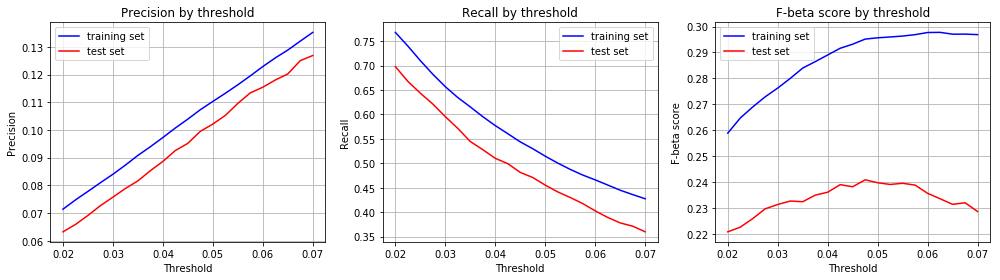

In [14]:
# -------------------- Find best threshold -------------------- #
#pct_pos = 0.10   # <-- tune: increase leads to higher recall, less precision
beta = 2
precision_tr_all, recall_tr_all, accuracy_tr_all = [], [], []
precision_t_all, recall_t_all, accuracy_t_all = [], [], [] 
fbeta_tr_all, fbeta_t_all = [], []
thresholds = [0.02, 0.0225, 0.025, 0.0275, 0.03, 0.0325, 0.035, 0.0375, 0.040, 0.0425, \
              0.045, 0.0475, 0.05, 0.0525, 0.055, 0.0575, 0.06, 0.0625, 0.065, 0.0675, 0.07]
for threshold in thresholds:
    precision_tr, recall_tr, accuracy_tr = [], [], []
    precision_t, recall_t, accuracy_t = [], [], []
    y_pred_t_bin_all, y_pred_tr_bin_all = [], []
    score_fbeta_tr, score_fbeta_t = [], []
    for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                    y_pred_tr_all, y_pred_t_all):
        #y_pred_tr_bin = y_pred_tr > np.percentile(y_pred_tr, 100 * (1-pct_pos))
        y_pred_tr_bin = y_pred_tr > threshold
        y_pred_tr_bin = y_pred_tr_bin.astype(int)
        y_pred_tr_bin_all.append(y_pred_tr_bin)
        precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
        recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
        accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
        score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
        #y_pred_t_bin = y_pred_t > np.percentile(y_pred_t, 100 * (1-pct_pos))
        y_pred_t_bin = y_pred_t > threshold
        y_pred_t_bin = y_pred_t_bin.astype(int)
        y_pred_t_bin_all.append(y_pred_t_bin)
        precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
        recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
        accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
        score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))
    precision_tr_all.append(np.mean(precision_tr)) 
    precision_t_all.append(np.mean(precision_t)) 
    recall_tr_all.append(np.mean(recall_tr)) 
    recall_t_all.append(np.mean(recall_t))
    accuracy_tr_all.append(np.mean(accuracy_tr)) 
    accuracy_t_all.append(np.mean(accuracy_t))
    fbeta_tr_all.append(np.mean(score_fbeta_tr))
    fbeta_t_all.append(np.mean(score_fbeta_t))
rcParams['figure.figsize'] = 14, 4
plt.subplot(1,3,1)
plt.plot(thresholds, precision_tr_all, color='blue')
plt.plot(thresholds, precision_t_all, color='red')
plt.title('Precision by threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend(['training set', 'test set'])
plt.grid()
plt.subplot(1,3,2)
plt.plot(thresholds, recall_tr_all, color='blue')
plt.plot(thresholds, recall_t_all, color='red')
plt.title('Recall by threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.legend(['training set', 'test set'])
plt.grid()
plt.subplot(1,3,3)
plt.plot(thresholds, fbeta_tr_all, color='blue')
plt.plot(thresholds, fbeta_t_all, color='red')
plt.title('F-beta score by threshold')
plt.xlabel('Threshold')
plt.ylabel('F-beta score')
plt.legend(['training set', 'test set'])
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
# -------------------- Evaluate results -------------------- #
# pct_pos = 0.10   # <-- tune: increase leads to higher recall, less precision
threshold = 0.055
precision_tr, recall_tr, accuracy_tr = [], [], []
precision_t, recall_t, accuracy_t = [], [], []
y_pred_t_bin_all, y_pred_tr_bin_all = [], []
score_fbeta_tr, score_fbeta_t = [], []
for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                y_pred_tr_all, y_pred_t_all):
    #y_pred_tr_bin = y_pred_tr > np.percentile(y_pred_tr, 100 * (1-pct_pos))
    y_pred_tr_bin = y_pred_tr > threshold
    y_pred_tr_bin = y_pred_tr_bin.astype(int)
    y_pred_tr_bin_all.append(y_pred_tr_bin)
    precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
    recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
    accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
    score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
    #y_pred_t_bin = y_pred_t > np.percentile(y_pred_t, 100 * (1-pct_pos))
    y_pred_t_bin = y_pred_t > threshold
    y_pred_t_bin = y_pred_t_bin.astype(int)
    y_pred_t_bin_all.append(y_pred_t_bin)
    precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
    recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
    accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
    score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))

y_tr_pred_pos = [np.mean(y_pred) for y_pred in y_pred_tr_bin_all]
y_t_pred_pos = [np.mean(y_pred) for y_pred in y_pred_t_bin_all]
d = {'precision_tr': np.round(precision_tr,2), \
     'recall_tr': np.round(recall_tr,2), 'accuracy_tr': np.round(accuracy_tr,2), \
     'score_fbeta_tr': np.round(score_fbeta_tr,2), \
     'precision_t': np.round(precision_t,2), \
     'recall_t': np.round(recall_t,2), 'accuracy_t': np.round(accuracy_t,2), \
     'score_fbeta_t': np.round(score_fbeta_t,2)}
results = pd.DataFrame.from_dict(d, orient='index')
results.columns = dataset_names
print('Results - ' + model_name + ':')
print('\n')
print('Predict crash in:         ' + str(months) + ' months')
print('Number of epochs:         ' + str(epochs))
print('Sequence length:          ' + str(sequence))
print('Number of neurons/layer:  ' + str(neurons))
print('Batch size:               ' + str(batch_size))
print('Optimizer:                ' + str(optimizer))
print('Loss function:            ' + str(loss))
print('\n')
print('Results for each train/test split:')
print(results)
print('\n')

# calculate precision, recall, accuracy for comparable random model
sum_tr = 0
sum_t = 0
pos_tr = 0
pos_t = 0
sum_tr_pred = 0
sum_t_pred = 0
pos_tr_pred = 0
pos_t_pred = 0
for y_tr, y_t, y_tr_pr, y_t_pr in zip(y_train_all, y_test_all, y_pred_tr_bin_all, \
                y_pred_t_bin_all):
    sum_tr += len(y_tr)
    pos_tr += sum(y_tr)
    sum_t += len(y_t)
    pos_t += sum(y_t)
    sum_tr_pred += len(y_tr_pr)
    sum_t_pred += len(y_t_pr)
    pos_tr_pred += sum(y_tr_pr)[0]
    pos_t_pred += sum(y_t_pr)[0]
y_train_pos_actual = pos_tr / sum_tr
y_train_pos_pred = pos_tr_pred / sum_tr_pred
rnd_TP = y_train_pos_pred * y_train_pos_actual
rnd_FP = y_train_pos_pred * (1 - y_train_pos_actual)
rnd_TN = (1 - y_train_pos_pred) * (1 - y_train_pos_actual)
rnd_FN = (1 - y_train_pos_pred) * y_train_pos_actual
rnd_pr_tr = rnd_TP / (rnd_TP + rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP + rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
y_test_pos_actual = pos_t / sum_t
y_test_pos_pred = pos_t_pred / sum_t_pred
rnd_TP = y_test_pos_pred * y_test_pos_actual
rnd_FP = y_test_pos_pred * (1 - y_test_pos_actual)
rnd_TN = (1 - y_test_pos_pred) * (1 - y_test_pos_actual)
rnd_FN = (1 - y_test_pos_pred) * y_test_pos_actual
rnd_pr_t = rnd_TP / (rnd_TP + rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP + rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

print('Results average over all train/test splits:')
print('Number of features: ' + str(sequence) + '; number of rows: ' \
      + str(sum_tr + sum_t))
print('Positive train cases actual:        '+ str(round(y_train_pos_actual, 2)))
print('Positive train cases predicted:     '+ str(round(y_train_pos_pred, 2)))
print('Avg precision train (model/random): '+ str(round(np.mean(precision_tr), 2)) +' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(np.mean(recall_tr), 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(np.mean(accuracy_tr), 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train fbeta:                  '+ str(round(np.mean(score_fbeta_tr), 2)))
print('Positive test cases actual:         '+ str(round(y_test_pos_actual, 2)))
print('Positive test cases predicted:      '+ str(round(y_test_pos_pred, 2)))
print('Avg precision test (model/random):  '+ str(round(np.mean(precision_t), 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(np.mean(recall_t), 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(np.mean(accuracy_t), 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(np.mean(score_fbeta_t), 2)))

Results - RNN LSTM:


Predict crash in:         3 months
Number of epochs:         100
Sequence length:          5
Number of neurons/layer:  50
Batch size:               64
Optimizer:                adam
Loss function:            mse


Results for each train/test split:
                S&P 500  N225   SSE   HSI  BSESN   SMI  BVSP
precision_tr       0.10  0.13  0.12  0.11   0.13  0.11  0.11
recall_tr          0.53  0.51  0.46  0.52   0.46  0.46  0.49
accuracy_tr        0.76  0.83  0.83  0.80   0.84  0.82  0.79
score_fbeta_tr     0.29  0.33  0.29  0.30   0.30  0.28  0.29
precision_t        0.18  0.07  0.07  0.14   0.08  0.09  0.14
recall_t           0.21  0.34  0.69  0.21   0.46  0.60  0.50
accuracy_t         0.93  0.76  0.53  0.91   0.76  0.68  0.85
score_fbeta_t      0.21  0.19  0.24  0.19   0.23  0.29  0.33


Results average over all train/test splits:
Number of features: 5; number of rows: 430080
Positive train cases actual:        0.04
Positive train cases predicted:     0.19
Avg pr

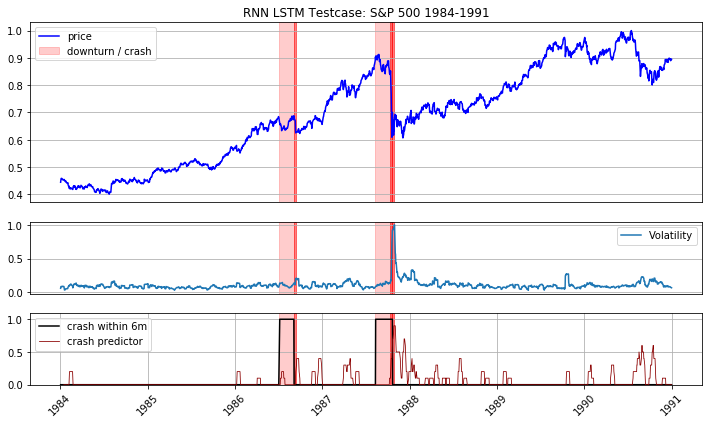

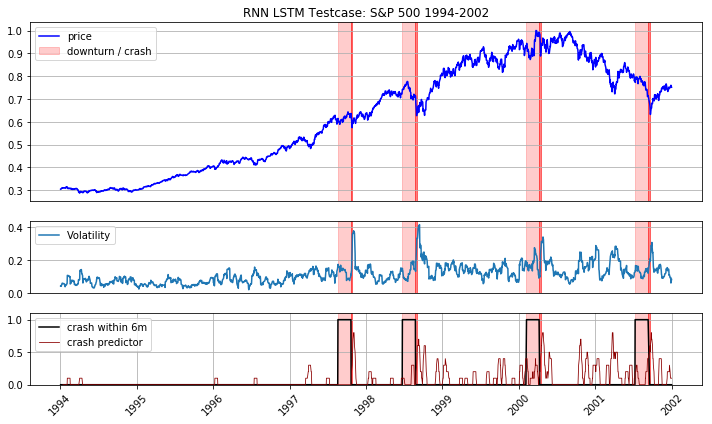

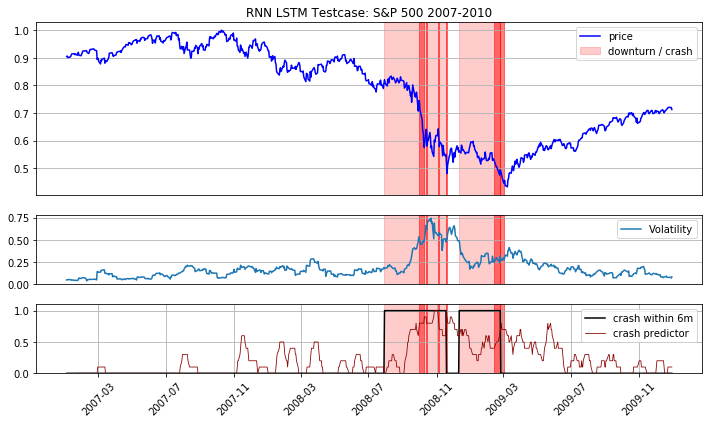

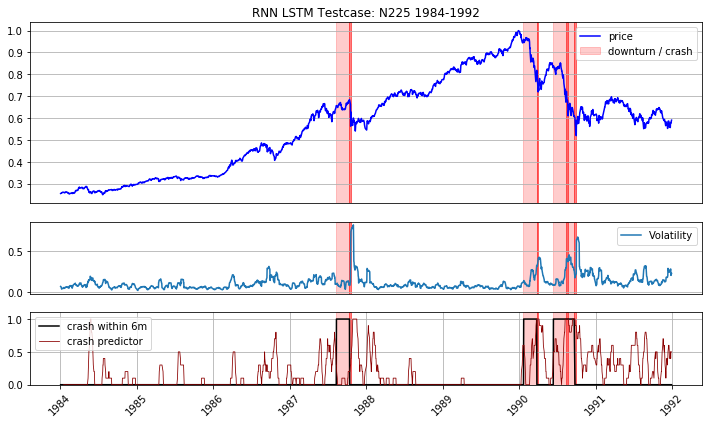

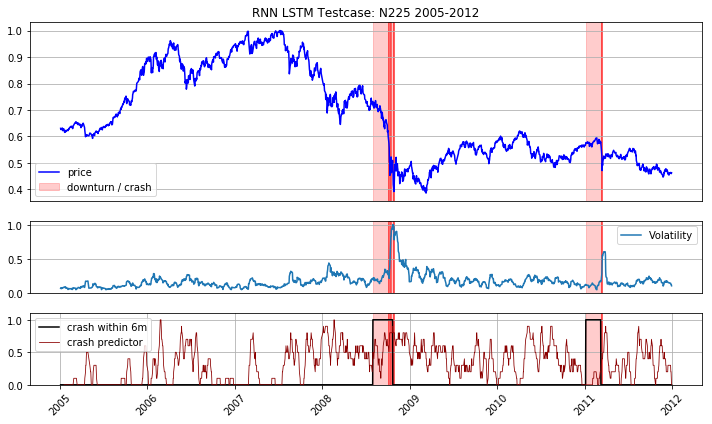

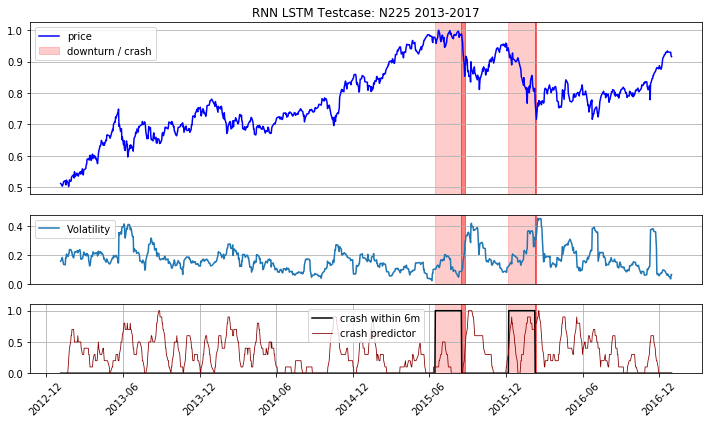

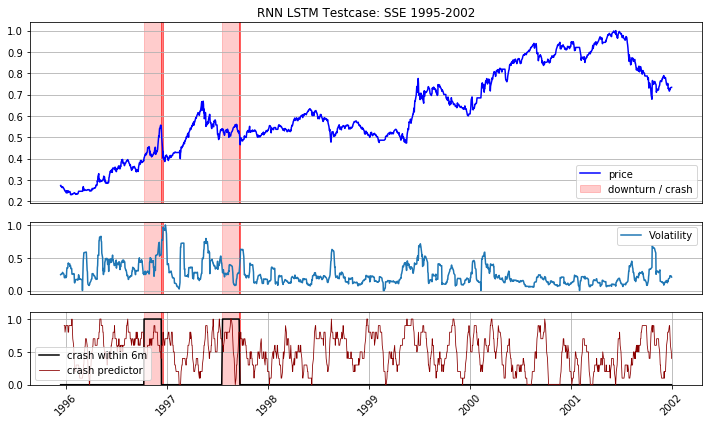

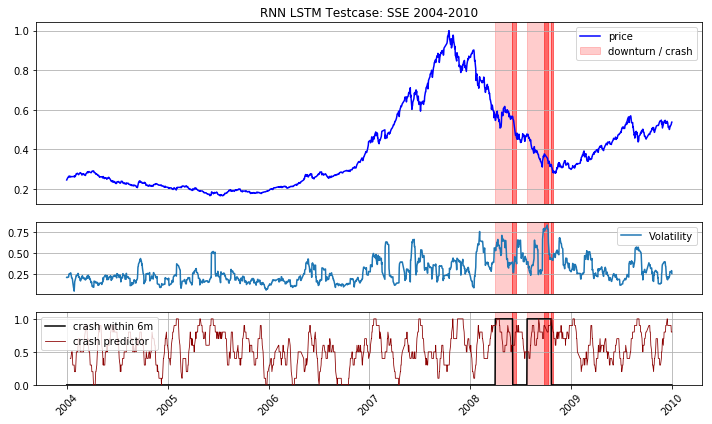

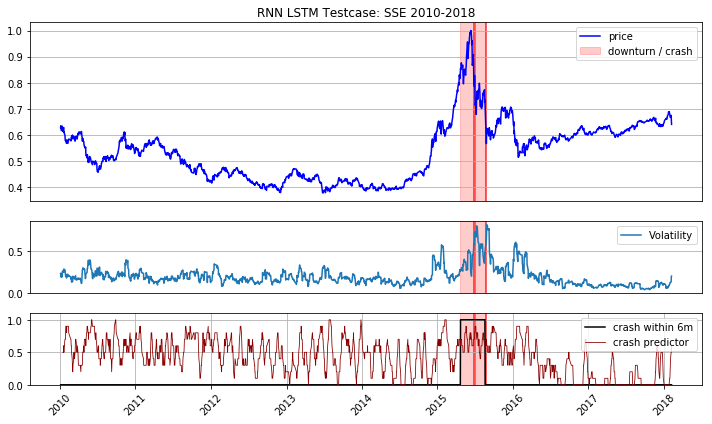

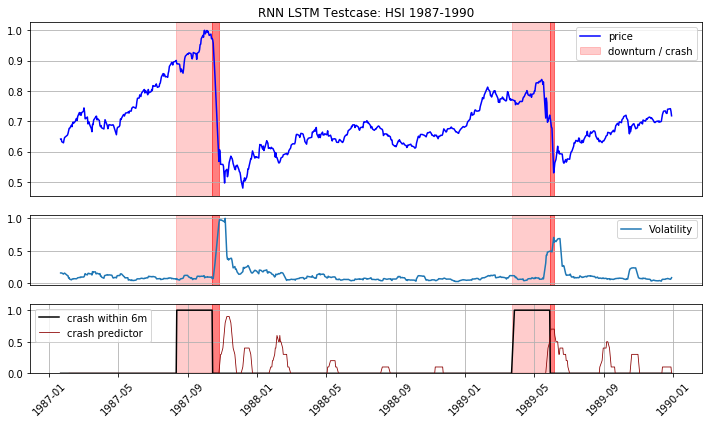

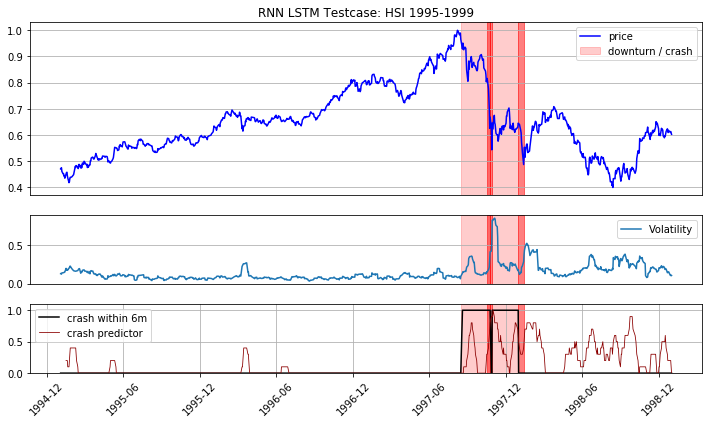

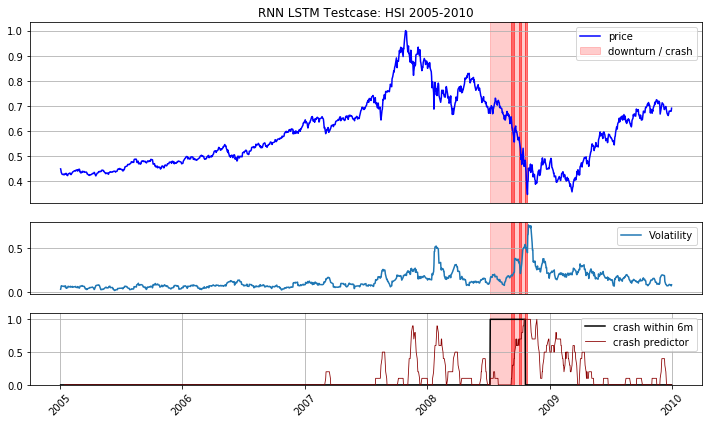

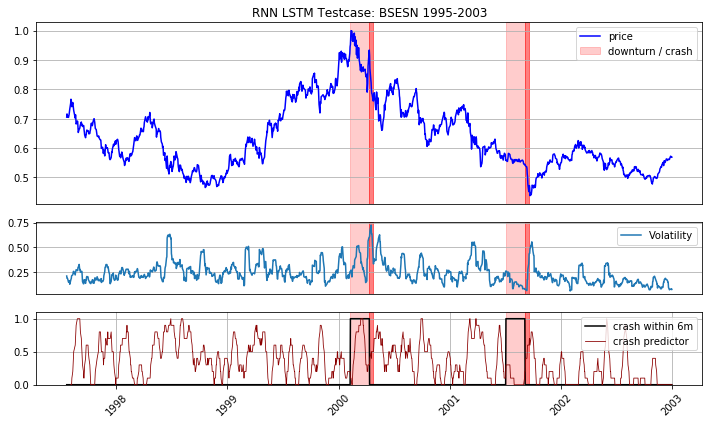

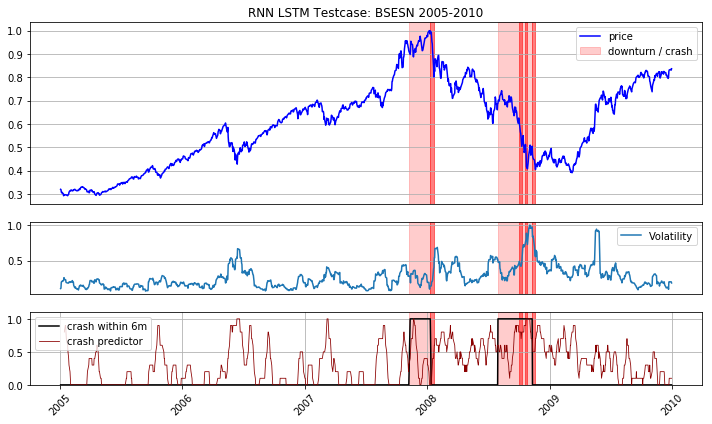

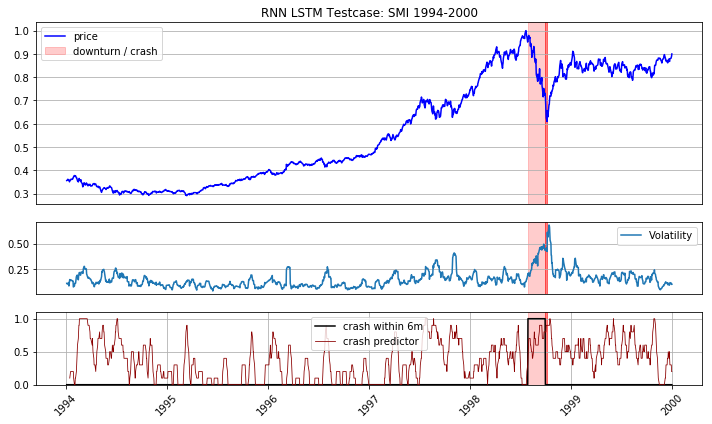

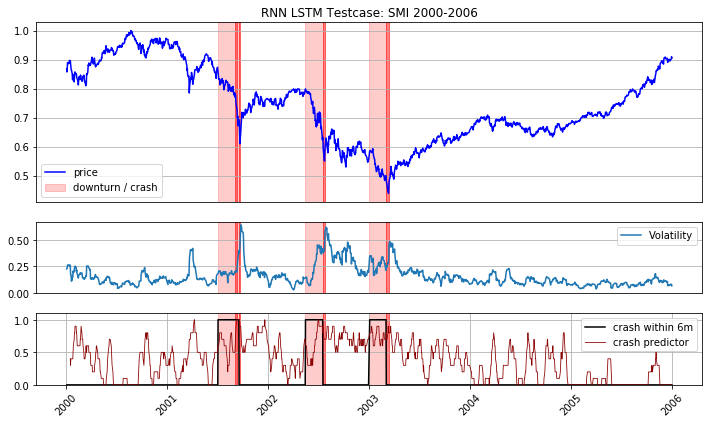

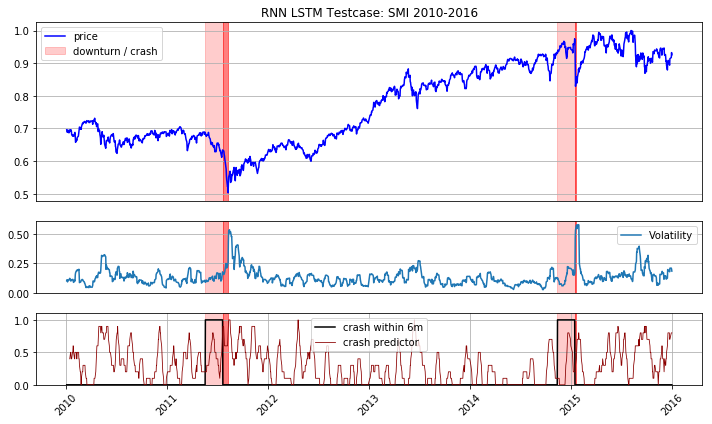

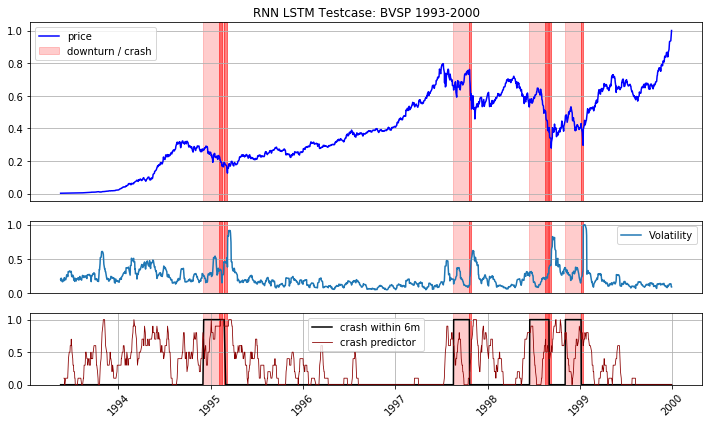

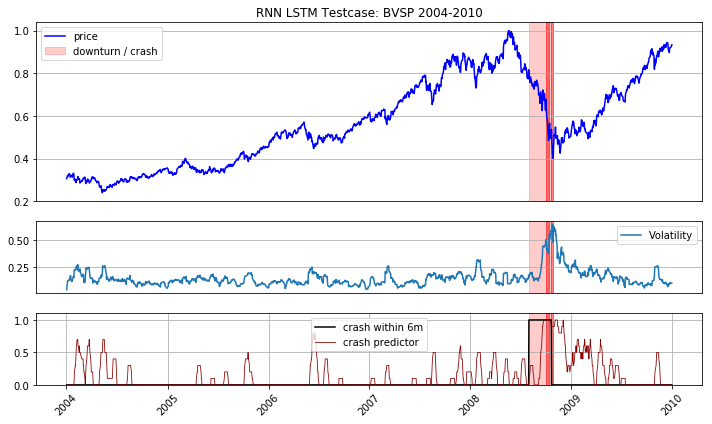

In [17]:
# -------------------- Plot results -------------------- #
test_data = 'S&P 500'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1984-01-01', '%Y-%m-%d'), datetime.strptime('1994-01-01', '%Y-%m-%d'), \
           datetime.strptime('2007-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1991-01-01', '%Y-%m-%d'), \
           datetime.strptime('2002-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

test_data = 'N225'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1984-01-01', '%Y-%m-%d'), datetime.strptime('2005-01-01', '%Y-%m-%d'), \
           datetime.strptime('2013-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1992-01-01', '%Y-%m-%d'), \
           datetime.strptime('2012-01-01', '%Y-%m-%d'), datetime.strptime('2017-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()      

test_data = 'SSE'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2002-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d'), df.index[-1]]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  
    
test_data = 'HSI'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('1995-01-01', '%Y-%m-%d'), \
           datetime.strptime('2005-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1990-01-01', '%Y-%m-%d'), \
           datetime.strptime('1999-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  
    
test_data = 'BSESN'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1995-01-01', '%Y-%m-%d'), datetime.strptime('2005-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2003-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

test_data = 'SMI'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1994-01-01', '%Y-%m-%d'), datetime.strptime('2000-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2000-01-01', '%Y-%m-%d'), \
           datetime.strptime('2006-01-01', '%Y-%m-%d'), datetime.strptime('2016-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

test_data = 'BVSP'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2000-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  